# Neural Network for ECG Classification



In this notebook, we will build a large neural network for ECG classification. The network will be designed to handle a complex dataset and will be trained to achieve high accuracy. The following sections will guide you through the process of creating, training, and evaluating the neural network.


#### IMPORTS

In [1]:
import torch
import numpy as np

from dataloader import MyCustomDataset
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim

import os
from model_nn import  Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
default_dir = os.getcwd()
def default_directory():
    os.chdir(f"{default_dir}")
    print(f"you are back to the default directory: {default_dir}")


In [3]:
default_directory()
os.getcwd()

you are back to the default directory: /home/karansingh/Documents/summer term/ECG_ML/MAIN


'/home/karansingh/Documents/summer term/ECG_ML/MAIN'

In [4]:
os.chdir("ML/data_4")
os.getcwd()

'/home/karansingh/Documents/summer term/ECG_ML/MAIN/ML/data_4'

#### LOAD DATA

In [5]:
## Create fake dataset for demonstration purposes

## Load your dataset and use 


data_ST_list = []
for i in range(10):
    cc = np.loadtxt('disease_ST_svd_'+str(i)+'.txt')
    data_ST_list.append(cc)
    print(f"data st of length {len(cc)} in {i} index loaded")


data_ST_list = np.array(data_ST_list)
images = np.resize(data_ST_list,(5000,10000))

labels=np.zeros(5000)

data_SB_list = []
for i in range(10):
    cc = np.loadtxt('disease_SB_svd_'+str(i)+'.txt')
    data_SB_list.append(cc)
    print(f"data sb of length {len(cc)} in {i} index loaded")
images = np.concatenate((images,np.resize(data_SB_list,(5000,10000))))
labels=np.concatenate((labels,np.ones(5000)))

data_SR_list = []
for i in range(10):
    cc = np.loadtxt('disease_SR_svd_'+str(i)+'.txt')
    data_SR_list.append(cc)
    print(f"data sr of length {len(cc)} in {i} index loaded")
images = np.concatenate((images,np.resize(data_SR_list,(5000,10000))))
labels=np.concatenate((labels,np.ones(5000)*2))
                    

data st of length 500 in 0 index loaded
data st of length 500 in 1 index loaded
data st of length 500 in 2 index loaded
data st of length 500 in 3 index loaded
data st of length 500 in 4 index loaded
data st of length 500 in 5 index loaded
data st of length 500 in 6 index loaded
data st of length 500 in 7 index loaded
data st of length 500 in 8 index loaded
data st of length 500 in 9 index loaded
data sb of length 500 in 0 index loaded
data sb of length 500 in 1 index loaded
data sb of length 500 in 2 index loaded
data sb of length 500 in 3 index loaded
data sb of length 500 in 4 index loaded
data sb of length 500 in 5 index loaded
data sb of length 500 in 6 index loaded
data sb of length 500 in 7 index loaded
data sb of length 500 in 8 index loaded
data sb of length 500 in 9 index loaded
data sr of length 500 in 0 index loaded
data sr of length 500 in 1 index loaded
data sr of length 500 in 2 index loaded
data sr of length 500 in 3 index loaded
data sr of length 500 in 4 index loaded


In [6]:
len(images),len(labels)

(15000, 15000)

#### CREATE BATCHES

In [7]:
# Create an instance of your dataset
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)
train_dataset = MyCustomDataset(images_train, labels_train)
test_dataset = MyCustomDataset(images_test, labels_test)
# Define a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### TRAINING PARAMETERS

In [8]:
# torch.manual_seed(37)  # Set seed for reproducibility
# model__ = Model()

# criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
# optimizer = optim.Adam(model__.parameters(), lr=0.001)  # Adam optimizer
# def accuracy(y_true, y_pred):
#     """ Calculates accuracy between truth labels and predictions.

#     Args:
#         y_true (torch.Tensor): Truth labels for predictions.
#         y_pred (torch.Tensor): Predictions to be compared to predictions.

#     Returns:
#         [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
#     """
#     correct = torch.eq(y_true, y_pred).sum().item()
#     acc = (correct / len(y_pred)) * 100
#     return acc


#### TRAINING

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    """Base model with 5 layers"""
    def __init__(self, in_features=10000, h1=2000, h2=500,
                 h3=200, h4=50, h5=10,
                 out_features=3, dropout_p=0.3):
        """Initialize an instance of the model"""
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, h4)
        self.fc5 = nn.Linear(h4, h5)
        self.out = nn.Linear(h5, out_features)
        self.dropout = nn.Dropout(p=dropout_p)  # Dropout layer

    def forward(self, x):
        """Forward method for the layers in the model"""
        # Using softmax in the output layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.out(x)
        return x


In [9]:
import copy
import torch
import torch.nn as nn

torch.manual_seed(27)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler (reduce LR when test loss plateaus)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

def correct(pred, true): 
    """Returns the number of correct predictions.
    which will use to calculate accuracy.
    """
    return (pred == true).sum().item()


num_epochs, patience = 25, 7
train_losses_list, test_losses_list, accuracy_train_list, accuracy_test_list = [], [], [], []
best_acc, wait, best_model = 0, 0, None

for epoch in range(num_epochs):
    # --- Train ---
    model.train(); run_loss = 0; c_train = t_train = 0
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        out = model(x); loss = criterion(out, y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        run_loss += loss.item()
        c_train += correct(out.argmax(1), y); t_train += y.size(0)
    train_losses_list.append(run_loss/len(train_dataloader))
    accuracy_train_list.append(100*c_train/t_train)

    # --- Test ---
    model.eval(); run_loss = 0; c_test = t_test = 0
    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x); loss = criterion(out, y)
            run_loss += loss.item()
            c_test += correct(out.argmax(1), y); t_test += y.size(0)
    test_losses_list.append(run_loss/len(test_dataloader))
    accuracy_test_list.append(100*c_test/t_test)

    # --- LR scheduler step ---
    scheduler.step(test_losses_list[-1])
    # Print LR (optional)
    lr_now = optimizer.param_groups[0]['lr']

    # --- Early stopping ---
    if accuracy_test_list[-1] > best_acc:
        best_acc, wait = accuracy_test_list[-1], 0
        best_model = copy.deepcopy(model.state_dict())
    else:
        wait += 1
        if wait >= patience:
            print(f"##Early stopping at epoch {epoch+1}##")
            break

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_losses_list[-1]:.4f}, Test Loss: {test_losses_list[-1]:.4f}, "
          f"Train Acc: {accuracy_train_list[-1]:.2f}, Test Acc: {accuracy_test_list[-1]:.2f}, "
          f"LR: {lr_now:.6f}")

# Restore best weights
model.load_state_dict(best_model)
print(f" Best Test Accuracy: {best_acc:.2f}")


Epoch [1/25] | Train Loss: 0.8238, Test Loss: 0.6595, Train Acc: 57.92, Test Acc: 71.53, LR: 0.001000
Epoch [2/25] | Train Loss: 0.5690, Test Loss: 0.5118, Train Acc: 76.54, Test Acc: 79.03, LR: 0.001000
Epoch [3/25] | Train Loss: 0.4039, Test Loss: 0.4072, Train Acc: 85.13, Test Acc: 85.27, LR: 0.001000
Epoch [4/25] | Train Loss: 0.3141, Test Loss: 0.4275, Train Acc: 88.38, Test Acc: 86.13, LR: 0.001000
Epoch [5/25] | Train Loss: 0.2774, Test Loss: 0.3977, Train Acc: 90.42, Test Acc: 85.93, LR: 0.001000
Epoch [6/25] | Train Loss: 0.2488, Test Loss: 0.4262, Train Acc: 91.30, Test Acc: 86.87, LR: 0.001000
Epoch [7/25] | Train Loss: 0.2246, Test Loss: 0.4511, Train Acc: 92.27, Test Acc: 87.50, LR: 0.001000
Epoch [8/25] | Train Loss: 0.2151, Test Loss: 0.4959, Train Acc: 92.41, Test Acc: 86.27, LR: 0.001000
Epoch [9/25] | Train Loss: 0.1973, Test Loss: 0.4733, Train Acc: 93.16, Test Acc: 86.23, LR: 0.000500
Epoch [10/25] | Train Loss: 0.1262, Test Loss: 0.4875, Train Acc: 95.59, Test Acc:

In [14]:
import copy
import torch
import torch.nn as nn

torch.manual_seed(27)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)

# Scheduler (reduce LR when test loss plateaus)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

def correct(pred, true): 
    """Returns the number of correct predictions.
    which will use to calculate accuracy.
    """
    return (pred == true).sum().item()


num_epochs, patience = 25, 7
train_losses_list, test_losses_list, accuracy_train_list, accuracy_test_list = [], [], [], []
best_acc, wait, best_model = 0, 0, None

for epoch in range(num_epochs):
    # --- Train ---
    model.train(); run_loss = 0; c_train = t_train = 0
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        out = model(x); loss = criterion(out, y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        run_loss += loss.item()
        c_train += correct(out.argmax(1), y); t_train += y.size(0)
    train_losses_list.append(run_loss/len(train_dataloader))
    accuracy_train_list.append(100*c_train/t_train)

    # --- Test ---
    model.eval(); run_loss = 0; c_test = t_test = 0
    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x); loss = criterion(out, y)
            run_loss += loss.item()
            c_test += correct(out.argmax(1), y); t_test += y.size(0)
    test_losses_list.append(run_loss/len(test_dataloader))
    accuracy_test_list.append(100*c_test/t_test)

    # --- LR scheduler step ---
    scheduler.step(test_losses_list[-1])
    # Print LR (optional)
    lr_now = optimizer.param_groups[0]['lr']

    # --- Early stopping ---
    if accuracy_test_list[-1] > best_acc:
        best_acc, wait = accuracy_test_list[-1], 0
        best_model = copy.deepcopy(model.state_dict())
    else:
        wait += 1
        if wait >= patience:
            print(f"##Early stopping at epoch {epoch+1}##")
            break

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_losses_list[-1]:.4f}, Test Loss: {test_losses_list[-1]:.4f}, "
          f"Train Acc: {accuracy_train_list[-1]:.2f}, Test Acc: {accuracy_test_list[-1]:.2f}, "
          f"LR: {lr_now:.6f}")

# Restore best weights
model.load_state_dict(best_model)
print(f" Best Test Accuracy: {best_acc:.2f}")



Epoch [1/25] | Train Loss: 0.9550, Test Loss: 0.7405, Train Acc: 48.91, Test Acc: 62.07, LR: 0.002000
Epoch [2/25] | Train Loss: 0.7728, Test Loss: 0.6924, Train Acc: 59.52, Test Acc: 60.53, LR: 0.002000
Epoch [3/25] | Train Loss: 0.7177, Test Loss: 0.6744, Train Acc: 63.38, Test Acc: 68.37, LR: 0.002000
Epoch [4/25] | Train Loss: 0.6924, Test Loss: 0.6519, Train Acc: 66.51, Test Acc: 70.37, LR: 0.002000
Epoch [5/25] | Train Loss: 0.6633, Test Loss: 0.5738, Train Acc: 69.93, Test Acc: 76.53, LR: 0.002000
Epoch [6/25] | Train Loss: 0.6268, Test Loss: 0.5390, Train Acc: 73.83, Test Acc: 79.53, LR: 0.002000
Epoch [7/25] | Train Loss: 0.5900, Test Loss: 0.5237, Train Acc: 76.17, Test Acc: 79.13, LR: 0.002000
Epoch [8/25] | Train Loss: 0.5766, Test Loss: 0.4859, Train Acc: 77.32, Test Acc: 81.67, LR: 0.002000
Epoch [9/25] | Train Loss: 0.5450, Test Loss: 0.5113, Train Acc: 79.25, Test Acc: 78.10, LR: 0.002000
Epoch [10/25] | Train Loss: 0.5395, Test Loss: 0.4885, Train Acc: 79.38, Test Acc:

In [13]:
import copy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# === CONFIG ===
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs, patience = 25, 7
seeds = range(20, 50)   # from 20 to 50

# To store results for all seeds
all_train_losses, all_test_losses = {}, {}
all_train_acc, all_test_acc = {}, {}

best_acc_overall, best_seed, best_model_state = 0, None, None

def correct(pred, true): 
    return (pred == true).sum().item()

# === LOOP OVER SEEDS ===
for seed in seeds:
    torch.manual_seed(seed)

    # Model, optimizer, scheduler
    model = Model().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=3
    )

    # Logs for this run
    train_losses_list, test_losses_list = [], []
    accuracy_train_list, accuracy_test_list = [], []

    best_acc, wait, best_model = 0, 0, None

    for epoch in range(num_epochs):
        # --- Train ---
        model.train(); run_loss = 0; c_train = t_train = 0
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x); loss = criterion(out, y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            run_loss += loss.item()
            c_train += correct(out.argmax(1), y); t_train += y.size(0)
        train_losses_list.append(run_loss/len(train_dataloader))
        accuracy_train_list.append(100*c_train/t_train)

        # --- Test ---
        model.eval(); run_loss = 0; c_test = t_test = 0
        with torch.no_grad():
            for x, y in test_dataloader:
                x, y = x.to(device), y.to(device)
                out = model(x); loss = criterion(out, y)
                run_loss += loss.item()
                c_test += correct(out.argmax(1), y); t_test += y.size(0)
        test_losses_list.append(run_loss/len(test_dataloader))
        accuracy_test_list.append(100*c_test/t_test)

        # --- LR schedule ---
        scheduler.step(test_losses_list[-1])

        # --- Early stopping ---
        if accuracy_test_list[-1] > best_acc:
            best_acc, wait = accuracy_test_list[-1], 0
            best_model = copy.deepcopy(model.state_dict())
            if best_acc > 98.6:
                print(f"Seed {seed}: Early stopping at epoch {epoch+1}")
                break
        else:
            wait += 1
            if wait >= patience:
                print(f"Seed {seed}: Early stopping at epoch {epoch+1}")
                break

    # Save results for this seed
    all_train_losses[seed] = train_losses_list
    all_test_losses[seed] = test_losses_list
    all_train_acc[seed] = accuracy_train_list
    all_test_acc[seed] = accuracy_test_list

    # Check if this seed gave the best accuracy overall
    if best_acc > best_acc_overall:
        best_acc_overall, best_seed = best_acc, seed
        best_model_state = best_model

    print(f"Seed {seed}: Best Test Accuracy = {best_acc:.2f}")

# === Save best model ===
print(f"\nBest overall seed = {best_seed}, Accuracy = {best_acc_overall:.2f}")


Seed 20: Early stopping at epoch 23
Seed 20: Best Test Accuracy = 90.03
Seed 21: Best Test Accuracy = 90.70
Seed 22: Best Test Accuracy = 90.47
Seed 23: Best Test Accuracy = 90.30
Seed 24: Best Test Accuracy = 90.17
Seed 25: Best Test Accuracy = 90.43
Seed 26: Best Test Accuracy = 90.23
Seed 27: Best Test Accuracy = 90.20
Seed 28: Best Test Accuracy = 90.50
Seed 29: Best Test Accuracy = 89.83
Seed 30: Early stopping at epoch 25
Seed 30: Best Test Accuracy = 90.17
Seed 31: Best Test Accuracy = 89.43
Seed 32: Best Test Accuracy = 90.03
Seed 33: Early stopping at epoch 23
Seed 33: Best Test Accuracy = 89.97
Seed 34: Best Test Accuracy = 89.83
Seed 35: Best Test Accuracy = 90.53
Seed 36: Best Test Accuracy = 89.97
Seed 37: Best Test Accuracy = 90.07
Seed 38: Best Test Accuracy = 90.07
Seed 39: Early stopping at epoch 23
Seed 39: Best Test Accuracy = 89.87
Seed 40: Early stopping at epoch 18
Seed 40: Best Test Accuracy = 90.20
Seed 41: Best Test Accuracy = 89.90
Seed 42: Best Test Accuracy 

In [ ]:
import pickle
import os
import ipynbname

# Get current notebook name
try:
    # Get notebook name (without .ipynb extension)
    notebook_name = ipynbname.name()

except:
    notebook_name = "Notebook"  # fallback if can't get notebook name

# Create folder with notebook name if it doesn't exist
if not os.path.exists(notebook_name):
    os.makedirs(notebook_name)

# Path to save
save_path = os.path.join(notebook_name, "all_results.pkl")

# Save results
results = {
    "train_losses": all_train_losses,
    "test_losses": all_test_losses,
    "train_acc": all_train_acc,
    "test_acc": all_test_acc,
    "best_seed": best_seed,
    "best_acc": best_acc_overall,
}

with open(save_path, "wb") as f:
    pickle.dump(results, f)

torch.save(best_model_state, os.path.join(notebook_name, f"best_model{best_seed}.pth"))

print(f" Saved all training histories to {save_path}")


Saved all training histories to main_1_ffnn_cg50_leg/all_results.pkl


In [16]:
# === Instantiate a new model object ===
model = model.to(device) 

# === Load the best saved state dict ===
model.load_state_dict(best_model_state)

# === Set to evaluation mode ===
model.eval()

print(f"Loaded best model from seed {best_seed} with accuracy {best_acc_overall:.2f}")


Loaded best model from seed 21 with accuracy 90.70


you are back to the default directory: /home/karansingh/Documents/summer term/ECG_ML/MAIN


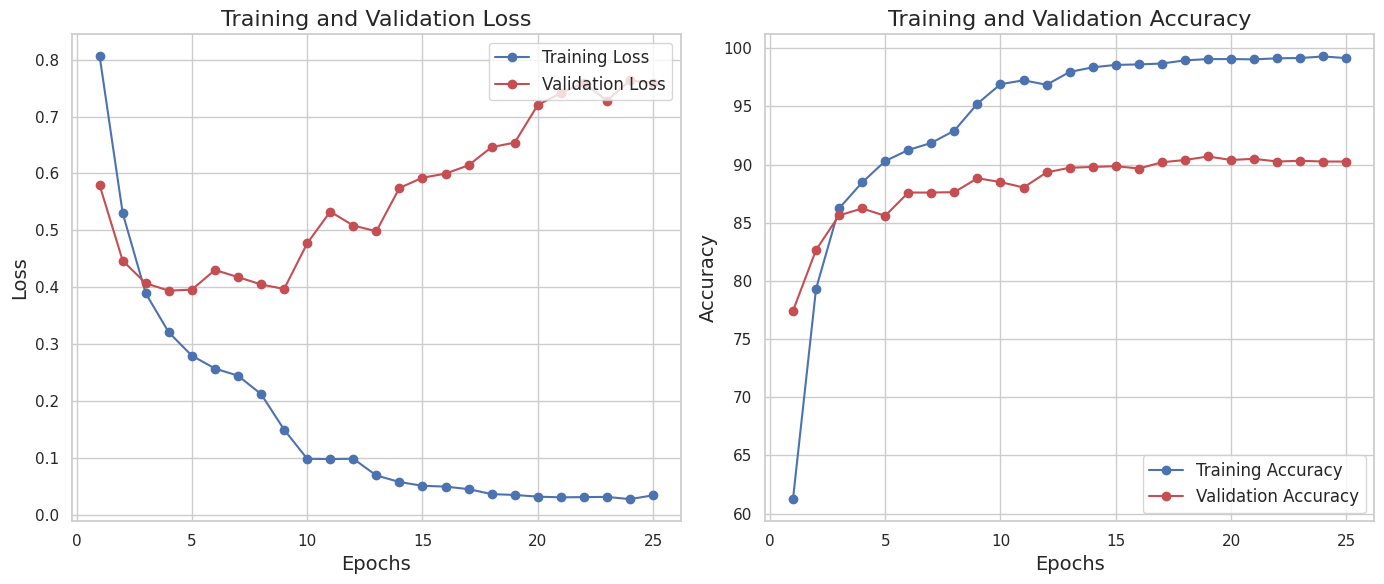

In [17]:
default_directory()
from plots import accuracy_and_validation_plots
epochs_= list(range(1, len(all_train_losses[best_seed])+1))
accuracy_and_validation_plots(epochs_,
    all_train_losses[best_seed],
    all_test_losses[best_seed],
    all_train_acc[best_seed],
    all_test_acc[best_seed]
).plot_figure("accuracy.png")


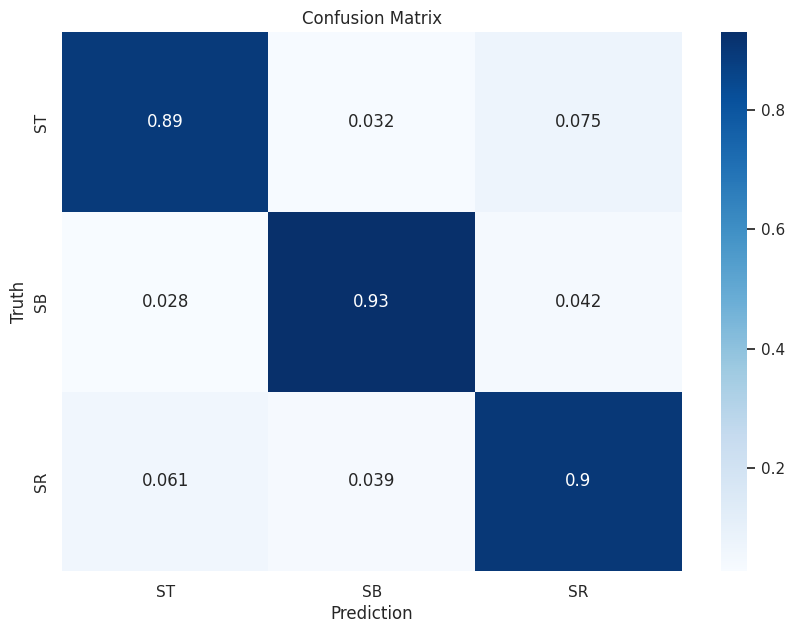

In [18]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import torch.nn.functional as F

model.eval()
y_pred = []
y_true = []
y_scores = []  # Added to collect probability scores

with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model(images.to(device))
        # Get probability scores using softmax
        probabilities = F.softmax(outputs, dim=1)
        y_scores.extend(probabilities.cpu().numpy())
        
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Convert to numpy arrays
y_scores = np.array(y_scores)

cm = confusion_matrix(y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix
df_cm = pd.DataFrame(cm, index=["ST", "SB", "SR"], columns=["ST", "SB", "SR"])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

In [19]:

#Classification Report for Test Data:

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["ST", "SB", "SR"]))


              precision    recall  f1-score   support

          ST       0.91      0.89      0.90      1037
          SB       0.93      0.93      0.93       970
          SR       0.88      0.90      0.89       993

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



Average precision score, micro-averaged over all classes: 0.96


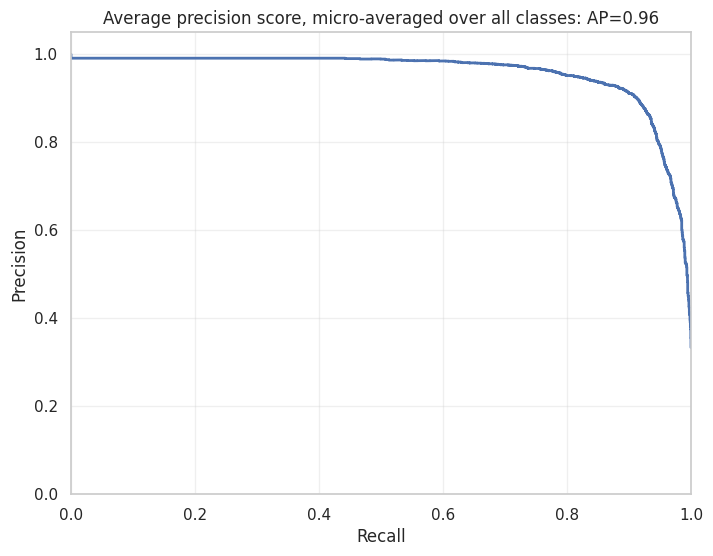

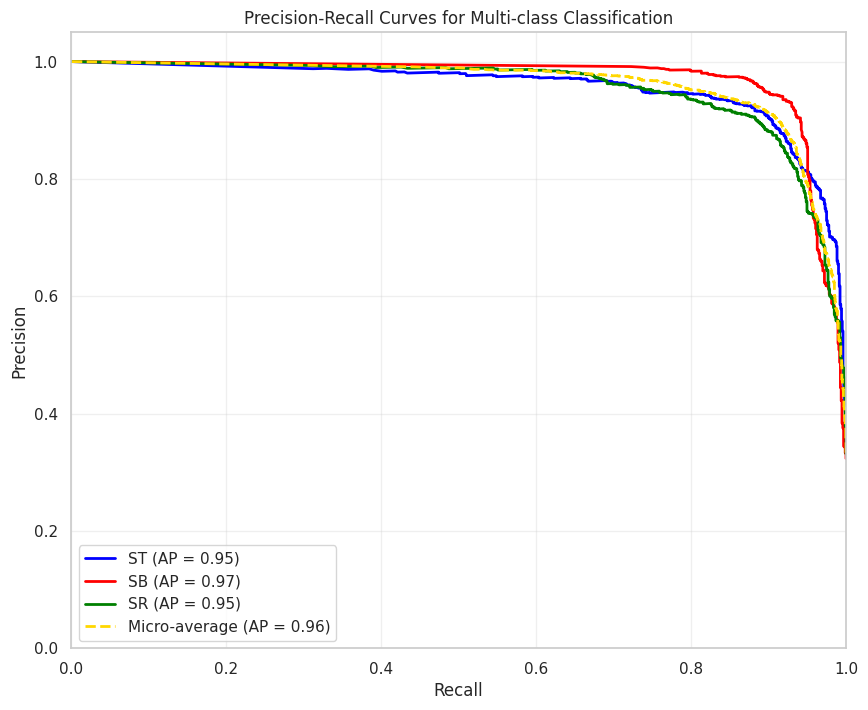

In [20]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()

# For each class, compute PR curve using probability scores
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(
        (np.array(y_true) == i).astype(int),  # Binary true labels for class i
        y_scores[:, i]  # Probability scores for class i
    )
    average_precision[i] = average_precision_score(
        (np.array(y_true) == i).astype(int), 
        y_scores[:, i]
    )

# Micro-average: using probability scores
from sklearn.preprocessing import label_binarize
y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_true_binary.ravel(),
    y_scores.ravel()
)
average_precision["micro"] = average_precision_score(
    y_true_binary, 
    y_scores,
    average="micro"
)

print('Average precision score, micro-averaged over all classes: {0:0.2f}'
        .format(average_precision["micro"]))

# Plot micro-average PR curve
plt.figure(figsize=(8, 6))
plt.step(recall['micro'], precision['micro'], where='post', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
plt.grid(True, alpha=0.3)
plt.show()

# Plot individual class PR curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
class_names = ['ST', 'SB', 'SR']

for i, color, class_name in zip(range(3), colors, class_names):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'{class_name} (AP = {average_precision[i]:0.2f})')

plt.plot(recall['micro'], precision['micro'], color='gold', lw=2, linestyle='--',
         label=f'Micro-average (AP = {average_precision["micro"]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curves for Multi-class Classification')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

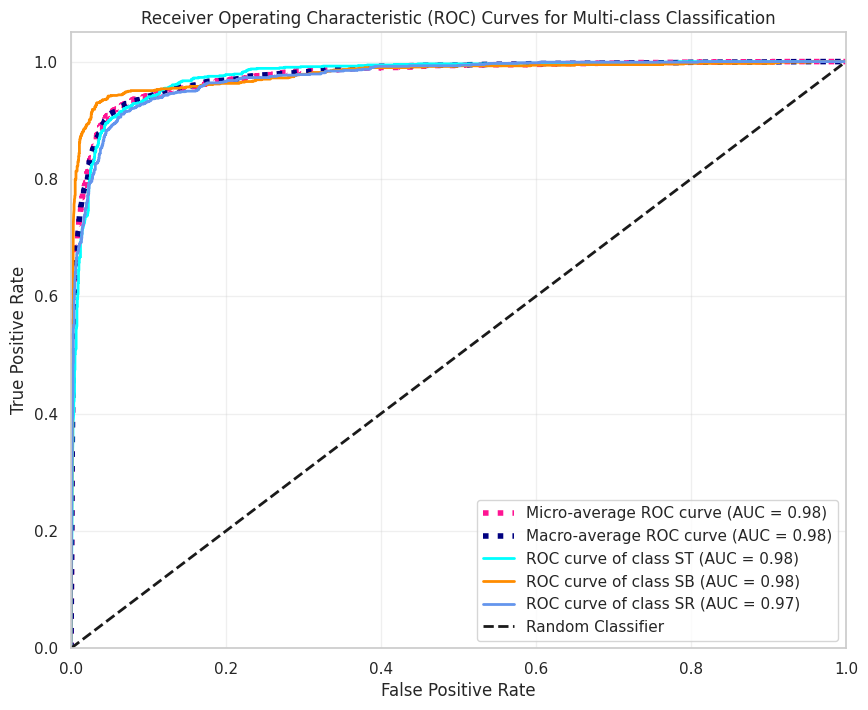

AUC Scores:
Class ST: 0.976
Class SB: 0.979
Class SR: 0.973
Micro-average: 0.976
Macro-average: 0.976


In [21]:
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the true labels for multi-class ROC
y_test = label_binarize(y_true, classes=[0, 1, 2])
# Use probability scores (not predictions!)
y_score = y_scores  # This contains the probability scores from softmax

n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = ['aqua', 'darkorange', 'cornflowerblue']
class_names = ['ST', 'SB', 'SR']

for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_name} (AUC = {roc_auc[i]:0.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multi-class Classification')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Print AUC scores
print("AUC Scores:")
for i, class_name in enumerate(['ST', 'SB', 'SR']):
    print(f"Class {class_name}: {roc_auc[i]:.3f}")
print(f"Micro-average: {roc_auc['micro']:.3f}")
print(f"Macro-average: {roc_auc['macro']:.3f}")